# Classification of Football Players' Positions
## Hands On Lab : Snowflake & Snowpark for End to End dataflow

This is an all-in-one Jupyter notebook covering the entire pipeline to build a ML model classifying football player positions in Snowpark. 

- The only step not included in this notebook is downloading the dataset from Kaggle which I recommend doing it directly from the source, it's free and it will take just a few seconds! Download the football dataset [here](https://www.kaggle.com/datasets/davidcariboo/player-scores).

- We will start by creating database objects and feature engineering views on Snowflake. 

- Once the data is prepared, we'll use **Snowpark to train and test a random forest model to predict football players' positions**. 

NOTE: Model accuracy is not the primary goal of this notebook; instead, it aims to provide a comprehensive, step-by-step example (on a very cool use case).

![Introduction - Design](https://github.com/matteo-consoli/hol_football_ml_snowpark/blob/main/images/design_football_ml_dark.png?raw=true)



# Data Ingestion & Feature Engineering

**Pre-Reqs**: `setup.md` instructions are executed succesffully. You have your conda env configured. Jupyter Notebook and libraries are installed. Let's start!

#### Step 1: Load Account Credentials

Modify the `config.json` file with your Snowflake account credentials . The file should look like this:

```json
{
  "user": "your_username",
  "password": "your_password",
  "account": "org-accountname",
  "role": "your_role",
}
```

Otherwise, adjust the code below to define connection parameters directly in the notebook. It's not considered a good practice, but I won't judge you!

In [1]:
# Import Python packages
import json
import sys
import cachetools
import sklearn 
import pandas as pd
from joblib import dump
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import label_binarize

# Import Snowflake modules
from snowflake.snowpark import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark import Window

In [2]:
# Get account credentials from a json file
with open("config.json") as f:
    data = json.load(f)
    username = data["user"]
    password = data["password"]
    account = data["account"]
    role = data["role"]
# If you don't want to use the config.json, I can feel you. 
# In that case, comment the line above and write the connection_parameters directly below as strings. 

# Specify connection parameters
connection_parameters = {
    "account": account,
    "user": username,
    "password": password,
    "role": role
}

# Create Snowpark session
session = Session.builder.configs(connection_parameters).create()

#### Step 2: Create Objects in Snowflake

Once connected, execute SQL commands directly from this notebook to create the database, schema, tables, and stages. Although not the most traditional option, it allows to run the entire pipeline directly from this notebook.

In [3]:
session.sql("CREATE DATABASE IF NOT EXISTS HOL_DB;").collect()
session.sql("CREATE SCHEMA IF NOT EXISTS HOL_DB.HOL_SNOWPARK_FOOTBALL;").collect()
session.sql("CREATE STAGE IF NOT EXISTS HOL_DB.HOL_SNOWPARK_FOOTBALL.FOOTBALL_DATASET_STAGE;").collect()
session.sql("CREATE STAGE IF NOT EXISTS HOL_DB.HOL_SNOWPARK_FOOTBALL.FOOTBALL_MODELS_REPO").collect()
session.sql("USE SCHEMA HOL_DB.HOL_SNOWPARK_FOOTBALL;").collect()
session.sql("""
    CREATE WAREHOUSE IF NOT EXISTS HOL_WH
    WAREHOUSE_SIZE = 'XSmall' 
    AUTO_SUSPEND=60 
    AUTO_RESUME=True;
""").collect()
session.sql("USE WAREHOUSE HOL_WH;").collect()

session.sql("""
    CREATE OR REPLACE FILE FORMAT HOL_DB.HOL_SNOWPARK_FOOTBALL.HOL_FOOTBALL_CSV_FILE_FORMAT
    TYPE = CSV
    FIELD_DELIMITER = ','
    FIELD_OPTIONALLY_ENCLOSED_BY='"'
    PARSE_HEADER = True
    TRIM_SPACE = TRUE
    NULL_IF = ('NULL', 'null')
    ESCAPE_UNENCLOSED_FIELD= NONE
    ERROR_ON_COLUMN_COUNT_MISMATCH=false;
""").collect()

[Row(status='File format HOL_FOOTBALL_CSV_FILE_FORMAT successfully created.')]

#### Step 3: Download the Dataset and Load Files into Snowflake Stage

- Download the dataset from [Kaggle](https://www.kaggle.com/datasets/davidcariboo/player-scores).
- Define the local directory where you saved the downloaded dataset. Adjust the `localpath` variable accordingly:

```python
localpath = '/Users/mconsoli/Desktop/hol_football_ml_snowpark/dataset'
```
This step will push all the files into the Snowflake stage, it might take a while. 
Standard Ingestion approaches for Snowflake usually are usually: Batch Loading (e.g. from S3 buckets for AWS), Snowpipe, Snowpipe Streaming.

In [4]:
localpath= '/Users/mconsoli/Desktop/hol_football_ml_snowpark/dataset'

files = [
    "club_games.csv",
    "appearances.csv",
    "clubs.csv",
    "competitions.csv",
    "game_events.csv",
    "game_lineups.csv",
    "games.csv",
    "players.csv",
    "player_valuations.csv"
]

for file in files:
    filepath = f"{localpath}/{file}"
    stage_path = f"@HOL_DB.HOL_SNOWPARK_FOOTBALL.FOOTBALL_DATASET_STAGE/"
    put_command = f"PUT 'file://{filepath}' '{stage_path}' AUTO_COMPRESS=false OVERWRITE=true"

    try:
        print(f"Loading '{file}' to stage.")
        result = session.sql(put_command).collect()
        print(f"File '{file}' successfully uploaded.")
    except Exception as e:
        print(f"Error uploading file '{file}': {str(e)}")

Loading 'club_games.csv' to stage.
File 'club_games.csv' successfully uploaded.
Loading 'appearances.csv' to stage.
File 'appearances.csv' successfully uploaded.
Loading 'clubs.csv' to stage.
File 'clubs.csv' successfully uploaded.
Loading 'competitions.csv' to stage.
File 'competitions.csv' successfully uploaded.
Loading 'game_events.csv' to stage.
File 'game_events.csv' successfully uploaded.
Loading 'game_lineups.csv' to stage.
File 'game_lineups.csv' successfully uploaded.
Loading 'games.csv' to stage.
File 'games.csv' successfully uploaded.
Loading 'players.csv' to stage.
File 'players.csv' successfully uploaded.
Loading 'player_valuations.csv' to stage.
File 'player_valuations.csv' successfully uploaded.


In [5]:
pd.DataFrame(session.sql("LIST @HOL_DB.HOL_SNOWPARK_FOOTBALL.FOOTBALL_DATASET_STAGE").collect())

,name,size,md5,last_modified
0,football_dataset_stage/appearances.csv,118447008,f2c0ac27909e019b1388a1de4c443427,"Mon, 11 Dec 2023 13:22:57 GMT"
1,football_dataset_stage/club_games.csv,8086352,d5ac5526896fa7f2158308dd4a19e8be,"Mon, 11 Dec 2023 13:22:36 GMT"
2,football_dataset_stage/clubs.csv,96016,b9843aedb206571287be80bcaf12ef87,"Mon, 11 Dec 2023 13:24:10 GMT"
3,football_dataset_stage/competitions.csv,6992,af8dbcfda2e0c65290a13636fa553e2e,"Mon, 11 Dec 2023 13:24:11 GMT"
4,football_dataset_stage/game_events.csv,67314016,422be6b45e22db772196d61f3d3adee5,"Mon, 11 Dec 2023 13:24:17 GMT"
5,football_dataset_stage/game_lineups.csv,12482960,db1d838a05adab83f26840fc4d0a6f70,"Mon, 11 Dec 2023 13:24:51 GMT"
6,football_dataset_stage/games.csv,17931904,7c24046e252c6720a33d70f7595bc516,"Mon, 11 Dec 2023 13:24:59 GMT"
7,football_dataset_stage/player_valuations.csv,31432944,ebf2548f6814b8ea890509686334e255,"Mon, 11 Dec 2023 13:25:22 GMT"
8,football_dataset_stage/players.csv,9923008,9c84267c712b819c4c3504da80f5dc17,"Mon, 11 Dec 2023 13:25:11 GMT"


#### Step 4: Load Files into Snowflake Tables

Now that the dataset files are in the Snowflake stage, the next step is to create tables and load the data. Execute the following SQL script in Snowflake to achieve this.

In [6]:
tables = ["club_games", "appearances", "clubs", "competitions", "game_events", "game_lineups", "games", "players", "player_valuations"]
for table in tables:
    session.sql(f"""
        CREATE OR REPLACE TABLE HOL_DB.HOL_SNOWPARK_FOOTBALL.{table.upper()}
        USING TEMPLATE (
            SELECT ARRAY_AGG(object_construct(*))
            FROM TABLE(
                INFER_SCHEMA(
                    LOCATION=>'@FOOTBALL_DATASET_STAGE/{table}.csv',
                    FILE_FORMAT=>'HOL_DB.HOL_SNOWPARK_FOOTBALL.HOL_FOOTBALL_CSV_FILE_FORMAT',
                    IGNORE_CASE => TRUE
                )
            )
        );
    """).collect()
    session.sql(f"""
        COPY INTO HOL_DB.HOL_SNOWPARK_FOOTBALL.{table.upper()}
        FROM '@FOOTBALL_DATASET_STAGE/{table}.csv'
        FILE_FORMAT = HOL_DB.HOL_SNOWPARK_FOOTBALL.HOL_FOOTBALL_CSV_FILE_FORMAT
        MATCH_BY_COLUMN_NAME = CASE_INSENSITIVE;
    """).collect()


#### Step 5: Feature Engineering

Given the small the dataset, a straightforward approach for feature engineering is creating views that consolidate player statistics and encode the POSITION (target column) as integers.

**Approach**

1. **Consolidating Player Statistics:**
   - Views like `PLAYER_VALUATION_STATS_VIEW` aggregate player statistics, including total goals, appearances, yellow cards, red cards, assists, and the latest market value.
   - A common theme across these views is to extract meaningful insights from the available player data.

2. **Position Encoding:**
   - The `PLAYER_AGGREGATE_STATS_DETAILS_VIEW` involves encoding the POSITION column as an integer to simplify model classification algorithm.
   - Positions like 'Goalkeeper,' 'Defender,' 'Midfield,' and 'Attack' are numerically encoded to facilitate machine learning tasks.

**Encoding Mapping**
- WHEN P.POSITION = 'Goalkeeper' THEN 0
- WHEN P.POSITION = 'Defender' THEN 1
- WHEN P.POSITION = 'Midfield' THEN 2
- WHEN P.POSITION = 'Attack' THEN 3

![Feature Engineering - Views Diagram](https://github.com/matteo-consoli/hol_football_ml_snowpark/blob/main/images/design_footbal_ml_feature_enginnering_dark.png?raw=true)

In [7]:
# View: PLAYER_VALUATION_STATS_VIEW
session.sql("""
CREATE OR REPLACE VIEW HOL_DB.HOL_SNOWPARK_FOOTBALL.PLAYER_VALUATION_STATS_VIEW AS
WITH LatestMarketValue AS (
    SELECT
        PLAYER_ID,
        EXTRACT(YEAR FROM DATE) AS YEAR,
        MAX(DATETIME) AS LATEST_DATETIME
    FROM
        HOL_DB.HOL_SNOWPARK_FOOTBALL.PLAYER_VALUATIONS
    GROUP BY
        PLAYER_ID,
        EXTRACT(YEAR FROM DATE)
)
SELECT
    A.PLAYER_ID,
    EXTRACT(YEAR FROM A.DATE) AS YEAR,
    SUM(A.GOALS) AS TOTAL_GOALS,
    COUNT(A.APPEARANCE_ID) AS TOTAL_APPEARANCES,
    SUM(A.YELLOW_CARDS) AS TOTAL_YELLOW_CARDS,
    SUM(A.RED_CARDS) AS TOTAL_RED_CARDS,
    SUM(A.ASSISTS) AS TOTAL_ASSISTS,
    COALESCE(P.MARKET_VALUE_IN_EUR, 0) AS LATEST_MARKET_VALUE_IN_EUR
FROM
    HOL_DB.HOL_SNOWPARK_FOOTBALL.APPEARANCES A
LEFT JOIN
    LatestMarketValue LMV
ON
    A.PLAYER_ID = LMV.PLAYER_ID
    AND EXTRACT(YEAR FROM A.DATE) = LMV.YEAR
LEFT JOIN
    HOL_DB.HOL_SNOWPARK_FOOTBALL.PLAYER_VALUATIONS P
ON
    A.PLAYER_ID = P.PLAYER_ID
    AND LMV.LATEST_DATETIME = P.DATETIME
GROUP BY
    A.PLAYER_ID,
    EXTRACT(YEAR FROM A.DATE),
    P.MARKET_VALUE_IN_EUR;
""").collect()

# View: PLAYER_COMPETITION_YEAR_STATS_DETAILS_VIEW
session.sql("""
CREATE OR REPLACE VIEW HOL_DB.HOL_SNOWPARK_FOOTBALL.PLAYER_COMPETITION_YEAR_STATS_DETAILS_VIEW AS
SELECT
    A.PLAYER_ID,
    A.COMPETITION_ID,
    C.NAME AS COMPETITION_NAME,
    C.SUB_TYPE AS COMPETITION_SUB_TYPE,
    C.TYPE AS COMPETITION_TYPE,
    EXTRACT(YEAR FROM A.DATE) AS YEAR,
    COUNT(A.APPEARANCE_ID) AS APPEARANCES_IN_COMPETITION,
    SUM(A.GOALS) AS TOTAL_GOALS,
    SUM(A.ASSISTS) AS TOTAL_ASSISTS,
    SUM(A.YELLOW_CARDS) AS TOTAL_YELLOW_CARDS,
    SUM(A.RED_CARDS) AS TOTAL_RED_CARDS
FROM
    HOL_DB.HOL_SNOWPARK_FOOTBALL.APPEARANCES A
JOIN
    HOL_DB.HOL_SNOWPARK_FOOTBALL.GAMES G
ON
    A.GAME_ID = G.GAME_ID
JOIN
    HOL_DB.HOL_SNOWPARK_FOOTBALL.COMPETITIONS C
ON
    A.COMPETITION_ID = C.COMPETITION_ID
GROUP BY
    A.PLAYER_ID,
    A.COMPETITION_ID,
    C.NAME,
    C.SUB_TYPE,
    C.TYPE,
    EXTRACT(YEAR FROM A.DATE);
""").collect()

# View: PLAYER_VALUATION_DELTA_VIEW
session.sql("""
CREATE OR REPLACE VIEW HOL_DB.HOL_SNOWPARK_FOOTBALL.PLAYER_VALUATION_DELTA_VIEW AS
SELECT
    PLAYER_ID,
    YEAR,
    TOTAL_GOALS,
    TOTAL_APPEARANCES,
    TOTAL_YELLOW_CARDS,
    TOTAL_RED_CARDS,
    TOTAL_ASSISTS,
    LATEST_MARKET_VALUE_IN_EUR,
    COALESCE(LAG(LATEST_MARKET_VALUE_IN_EUR) OVER (PARTITION BY PLAYER_ID ORDER BY YEAR), 0) AS PREVIOUS_MARKET_VALUE_IN_EUR,
    LATEST_MARKET_VALUE_IN_EUR - COALESCE(LAG(LATEST_MARKET_VALUE_IN_EUR) OVER (PARTITION BY PLAYER_ID ORDER BY YEAR), 0) AS MARKET_VALUE_DELTA,
    CASE
        WHEN COALESCE(LAG(LATEST_MARKET_VALUE_IN_EUR) OVER (PARTITION BY PLAYER_ID ORDER BY YEAR), 0) != 0
        THEN (LATEST_MARKET_VALUE_IN_EUR - COALESCE(LAG(LATEST_MARKET_VALUE_IN_EUR) OVER (PARTITION BY PLAYER_ID ORDER BY YEAR), 0)) / COALESCE(LAG(LATEST_MARKET_VALUE_IN_EUR) OVER (PARTITION BY PLAYER_ID ORDER BY YEAR), 0) * 100
        ELSE 0
    END AS MARKET_VALUE_DELTA_PERCENT
FROM
    HOL_DB.HOL_SNOWPARK_FOOTBALL.PLAYER_VALUATION_STATS_VIEW;
""").collect()

# View: PLAYER_AGGREGATE_STATS_DETAILS_VIEW
session.sql("""
CREATE OR REPLACE VIEW HOL_DB.HOL_SNOWPARK_FOOTBALL.PLAYER_AGGREGATE_STATS_DETAILS_VIEW AS
WITH PlayerDetails AS (
    SELECT
        P.PLAYER_ID,
        P.NAME,
        P.CURRENT_CLUB_NAME,
        P.CURRENT_CLUB_DOMESTIC_COMPETITION_ID,
        P.POSITION,
        CASE
            WHEN P.POSITION = 'Goalkeeper' THEN 0
            WHEN P.POSITION = 'Defender' THEN 1
            WHEN P.POSITION = 'Midfield' THEN 2
            WHEN P.POSITION = 'Attack' THEN 3
            ELSE '' END as POSITION_ENCODED,
        P.SUB_POSITION,
        P.HEIGHT_IN_CM,
        P.LAST_SEASON
    FROM
        HOL_DB.HOL_SNOWPARK_FOOTBALL.PLAYERS P
),
PlayerAggregatedStats AS (
    SELECT
        PV.PLAYER_ID,
        SUM(PV.TOTAL_GOALS) AS TOTAL_GOALS,
        SUM(PV.TOTAL_APPEARANCES) AS TOTAL_APPEARANCES,
        SUM(PV.TOTAL_YELLOW_CARDS) AS TOTAL_YELLOW_CARDS,
        SUM(PV.TOTAL_RED_CARDS) AS TOTAL_RED_CARDS,
        SUM(PV.TOTAL_ASSISTS) AS TOTAL_ASSISTS,
        COALESCE(MAX(PV.LATEST_MARKET_VALUE_IN_EUR), 0) AS LATEST_MARKET_VALUE_IN_EUR
    FROM
        HOL_DB.HOL_SNOWPARK_FOOTBALL.PLAYER_VALUATION_STATS_VIEW PV
    GROUP BY
        PV.PLAYER_ID
)
SELECT
    PD.PLAYER_ID,
    PD.NAME,
    PD.CURRENT_CLUB_NAME,
    PD.CURRENT_CLUB_DOMESTIC_COMPETITION_ID,
    PD.POSITION,
    PD.POSITION_ENCODED,
    PD.SUB_POSITION,
    PD.HEIGHT_IN_CM,
    PD.LAST_SEASON,
    PA.TOTAL_GOALS,
    PA.TOTAL_APPEARANCES,
    PA.TOTAL_YELLOW_CARDS,
    PA.TOTAL_RED_CARDS,
    PA.TOTAL_ASSISTS,
    PA.LATEST_MARKET_VALUE_IN_EUR
FROM
    PlayerDetails PD
LEFT JOIN
    PlayerAggregatedStats PA
ON
    PD.PLAYER_ID = PA.PLAYER_ID
WHERE PD.POSITION is not null and PD.POSITION != 'Missing';
""").collect()


[Row(status='View PLAYER_AGGREGATE_STATS_DETAILS_VIEW successfully created.')]

# Data Science - Model Training

It's time to delve into the ML side! Let's explore how we can train and perform inference in Snowpark / Snowflake. 

#### Step 1: Create Data Frame with the view containing prepared dataset

Define a Snowpark DataFrame based on the view created in the previous step, filtering only players and their statistics for the last season.



In [8]:
snowpark_df = session.table("HOL_DB.HOL_SNOWPARK_FOOTBALL.PLAYER_AGGREGATE_STATS_DETAILS_VIEW").filter(F.col("LAST_SEASON") == 2023)

In [9]:
# Show dataframe preview and count records.
snowpark_df.show()
snowpark_df.count()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"PLAYER_ID"  |"NAME"                    |"CURRENT_CLUB_NAME"  |"CURRENT_CLUB_DOMESTIC_COMPETITION_ID"  |"POSITION"  |"POSITION_ENCODED"  |"SUB_POSITION"    |"HEIGHT_IN_CM"  |"LAST_SEASON"  |"TOTAL_GOALS"  |"TOTAL_APPEARANCES"  |"TOTAL_YELLOW_CARDS"  |"TOTAL_RED_CARDS"  |"TOTAL_ASSISTS"  |"LATEST_MARKET_VALUE_IN_EUR"  |
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|126664       |Lucas Digne        

6537

#### Step 2: Split Dataset for Train and Test

Split the dataframe to train and test the models on different subsets of data.

In [10]:
session.sql("USE SCHEMA HOL_DB.HOL_SNOWPARK_FOOTBALL").collect()

train_snowpark_df, test_snowpark_df = snowpark_df.randomSplit([0.8, 0.2])
# Save training data
train_snowpark_df.write.mode("overwrite").save_as_table("HOL_DB.HOL_SNOWPARK_FOOTBALL.PLAYER_AGGREGATE_STATS_DETAILS_TRAIN")

# Save test data
test_snowpark_df.write.mode("overwrite").save_as_table("HOL_DB.HOL_SNOWPARK_FOOTBALL.PLAYER_AGGREGATE_STATS_DETAILS_TEST")



#### Step 3: Define Python Function for Random Forest Classifier


In [11]:
def train_random_forest_classifier(
    session: Session,
    training_table: str,
    feature_cols: list,
    target_col: str,
    model_name: str,
    n_estimators: int = 300,
    random_state: int = 100,
) -> T.Variant:

    # Get training data
    df = session.table(training_table).to_pandas()

    # Set inputs X and outputs y
    X = df[feature_cols]
    y = df[target_col]

    # Handle missing values using SimpleImputer
    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(X)

    # Train Random Forest Classifier
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
    model.fit(X_imputed, y)

    # Get feature importances
    feature_importances = pd.DataFrame({"Feature": feature_cols, "Importance": model.feature_importances_}).to_dict()

    # Save model
    dump(model, "/tmp/" + model_name)
    session.file.put(
        "/tmp/" + model_name,
        "@HOL_DB.HOL_SNOWPARK_FOOTBALL.FOOTBALL_MODELS_REPO",
        auto_compress=False,
        overwrite=True
    )

    # Return a Variant containing feature importances
    return {
        "feature_importances": feature_importances
    }


#### Step 4: Register Stored Procedure in Snowflake

The Stored Procedure is referencing the `train_random_forest_classifier` function defined in the previous step.

In [12]:
train_ranfor_snowflake = session.sproc.register(
    func=train_random_forest_classifier,
    name="HOL_DB.HOL_SNOWPARK_FOOTBALL.sproc_train_random_forest",
    is_permanent=True,
    replace=True,
    stage_location="@HOL_DB.HOL_SNOWPARK_FOOTBALL.FOOTBALL_MODELS_REPO",
    packages=["snowflake-snowpark-python", "scikit-learn", "joblib"]
)

The version of package 'snowflake-snowpark-python' in the local environment is 1.11.1, which does not fit the criteria for the requirement 'snowflake-snowpark-python'. Your UDF might not work when the package version is different between the server and your local environment.


#### Step 5: Train Model in Snowflake

Execute SPROC. Model generated is saved in a Snowflake stage.

In [13]:
# Specify inputs
training_table = "HOL_DB.HOL_SNOWPARK_FOOTBALL.PLAYER_AGGREGATE_STATS_DETAILS_TRAIN"
model_name = "randomforest_player_classification_model.sav"
feature_cols = [
    "TOTAL_GOALS",
    "TOTAL_APPEARANCES",
    "TOTAL_YELLOW_CARDS",
    "TOTAL_RED_CARDS",
    "TOTAL_ASSISTS",
    "LATEST_MARKET_VALUE_IN_EUR"
]
target_col = "POSITION_ENCODED"
# Call the training stored procedure
feature_contributions = train_ranfor_snowflake(
    session, training_table, feature_cols, target_col, model_name,100,42
)

#### Step 6: Validate Model Feature Importances

Check output of the SPROC, visualize Feature Importances and check which is the feature contributing the most to classify player's position.

HINT: Surely, NUM_GOALS is important! :) 

In [14]:
# Parse the string into a dictionary
result_dict = json.loads(feature_contributions)

# Extract Feature Importances
feature_importances = result_dict.get("feature_importances", {})
feature_importances_df = pd.DataFrame(feature_importances)
print(feature_importances_df)

#Optional Command below: list the models stored in Snowflake stage
#pd.DataFrame(session.sql("LIST @HOL_DB.HOL_SNOWPARK_FOOTBALL.FOOTBALL_MODELS_REPO").collect())

                      Feature  Importance
0                 TOTAL_GOALS    0.216025
1           TOTAL_APPEARANCES    0.267368
2          TOTAL_YELLOW_CARDS    0.162145
3             TOTAL_RED_CARDS    0.028382
4               TOTAL_ASSISTS    0.120317
5  LATEST_MARKET_VALUE_IN_EUR    0.205764


# Data Science - Model Inference Function & Testing

The SPROC built the model. It's time to create a UDF to apply inference on the `test_snowpark_df` (do you remember? We split the dataset at the beginning of the notebook)  

#### Step 1: Define Python Function

- Create an additional function `load_randomforest_model` to cache the model file.

- Define `randomforest_predict`.


In [15]:
# Function to load the RandomForestClassifier model from file and cache the result
@cachetools.cached(cache={})
def load_randomforest_model(filename):
    
    # Import packages
    import sys
    import os
    import joblib
    
    # Get the import directory where the model file is stored
    import_dir = sys._xoptions.get("snowflake_import_directory")
    
    # Get the import directory where the model file is stored
    if import_dir:
        with open(os.path.join(import_dir, filename), 'rb') as file:
            m = joblib.load(file)
            return m

# Function to predict using the RandomForestClassifier model with handling missing values
def randomforest_predict(X: pd.DataFrame) -> pd.Series:
    
    # Load the RandomForestClassifier model
    model = load_randomforest_model("randomforest_player_classification_model.sav")

    # Handle missing values using SimpleImputer
    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(X)

    # Get predictions
    predictions = pd.Series(model.predict(X_imputed))

    # Return predictions
    return predictions

#### Step 2: Register UDF Function in Snowflake

In [16]:
session.udf.register(
    func=randomforest_predict,
    name="HOL_DB.HOL_SNOWPARK_FOOTBALL.udf_randomforest_predict",
    stage_location="@HOL_DB.HOL_SNOWPARK_FOOTBALL.FOOTBALL_MODELS_REPO",
    input_types=[T.FloatType()] * len(feature_cols),
    return_type=T.FloatType(),
    replace=True,
    is_permanent=True,
    imports=["@HOL_DB.HOL_SNOWPARK_FOOTBALL.FOOTBALL_MODELS_REPO/randomforest_player_classification_model.sav"],
    packages=["scikit-learn", "joblib", "cachetools"]
)

#### Step 3: Inference Random Forest Classifier on Test Dataset

In [17]:
#Drop records not having the feature populated.
test_snowpark_df_drop_na = test_snowpark_df.dropna(subset=feature_cols)

test_pred = test_snowpark_df_drop_na.select(
    "*",
    F.call_udf("HOL_DB.HOL_SNOWPARK_FOOTBALL.UDF_RANDOMFOREST_PREDICT", [F.col(c) for c in feature_cols]).alias("prediction")
)
test_pred.show()

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"PLAYER_ID"  |"NAME"             |"CURRENT_CLUB_NAME"  |"CURRENT_CLUB_DOMESTIC_COMPETITION_ID"  |"POSITION"  |"POSITION_ENCODED"  |"SUB_POSITION"      |"HEIGHT_IN_CM"  |"LAST_SEASON"  |"TOTAL_GOALS"  |"TOTAL_APPEARANCES"  |"TOTAL_YELLOW_CARDS"  |"TOTAL_RED_CARDS"  |"TOTAL_ASSISTS"  |"LATEST_MARKET_VALUE_IN_EUR"  |"PREDICTION"  |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|297

# Evaluate Model Performance

Evaluate the performance of trained model on the test data. First the Snowpark DataFrame `test_pred` is converted into a Pandas DataFrame, then data is processed for evaluation. 

#### Step 1: Calculate Accuracy, Confusion Matrix, ROC-AUC
This involves handling missing values, binarizing labels, calculating accuracy, generating a confusion matrix, and calculating the ROC-AUC score for each class.


In [18]:
# Assuming test_pred_reverted is a Snowpark DataFrame
# Convert it to a Pandas DataFrame
test_pred_pd = test_pred.toPandas()
num_classes = 4
# Drop rows with missing values in the target variable
test_pred_pd = test_pred_pd.dropna(subset=["PREDICTION"])
test_pred_pd = test_pred_pd.dropna(subset=["POSITION_ENCODED"])

# Binarize the labels
y_true = label_binarize(test_pred_pd["POSITION_ENCODED"], classes=list(range(num_classes)))
y_pred = label_binarize(test_pred_pd["PREDICTION"], classes=list(range(num_classes)))

# Evaluate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy on test data: {accuracy:.2%}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))

# Convert numeric labels back to original string labels
conf_matrix_df = pd.DataFrame(conf_matrix, columns=range(num_classes), index=range(num_classes))

# Calculate ROC-AUC for each class
roc_auc_scores = []
for i in range(y_true.shape[1]):
    roc_auc = roc_auc_score(y_true[:, i], y_pred[:, i])
    roc_auc_scores.append(roc_auc)


Accuracy on test data: 57.55%


#### Step 2: Plot and Analize Results

**Confusion Matrix**

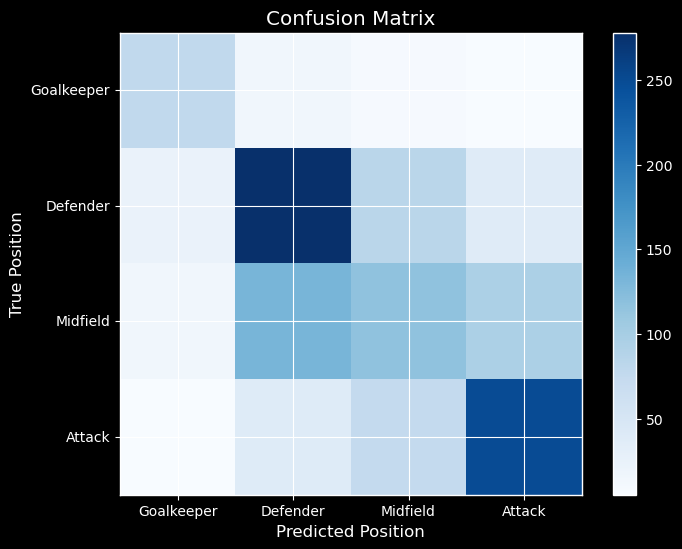

In [32]:
#plot confusion matrix and something else

import matplotlib.pyplot as plt
import seaborn as sns

# Set a dark background style for the plots. Why? Because it's cool! 
plt.style.use('dark_background')

# Convert numeric labels back to original string labels
position_labels = ['Goalkeeper', 'Defender', 'Midfield', 'Attack']

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_df, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = range(len(position_labels))
plt.xticks(tick_marks, position_labels, ha='center')  # Center x-axis labels
plt.yticks(tick_marks, position_labels, va='center')  # Center y-axis labels

plt.xlabel('Predicted Position')
plt.ylabel('True Position')
plt.show()

**ROC-AUC Scores**

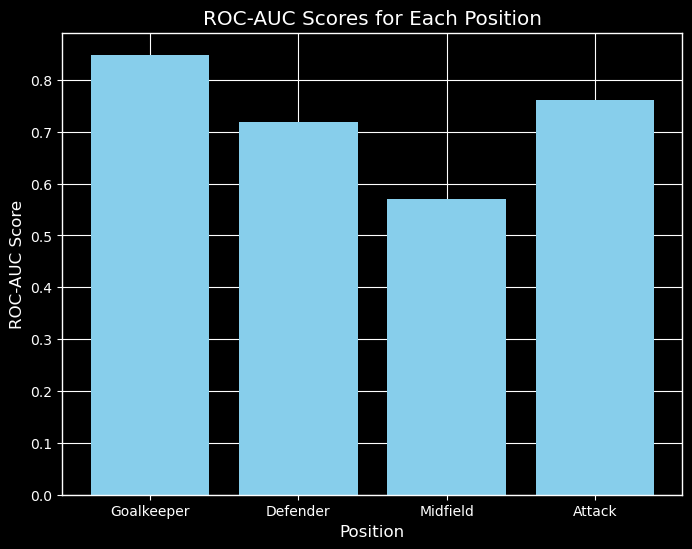

In [33]:
# Plot ROC-AUC Scores
plt.figure(figsize=(8, 6))
plt.bar(position_labels, roc_auc_scores, color='skyblue')
plt.title('ROC-AUC Scores for Each Position')
plt.xlabel('Position')
plt.ylabel('ROC-AUC Score')
plt.xticks(ha='center')  # Center x-axis labels
plt.show()

**Scatter Plot: Total Goals vs. Predicted Position**

The scatter plot illustrates the relationship between the total number of goals and the predicted player positions. As observed in the Confusion Matrix, the majority of attacking players are correctly classified, underscoring the significance of the "NUM_GOALS" feature in the model.


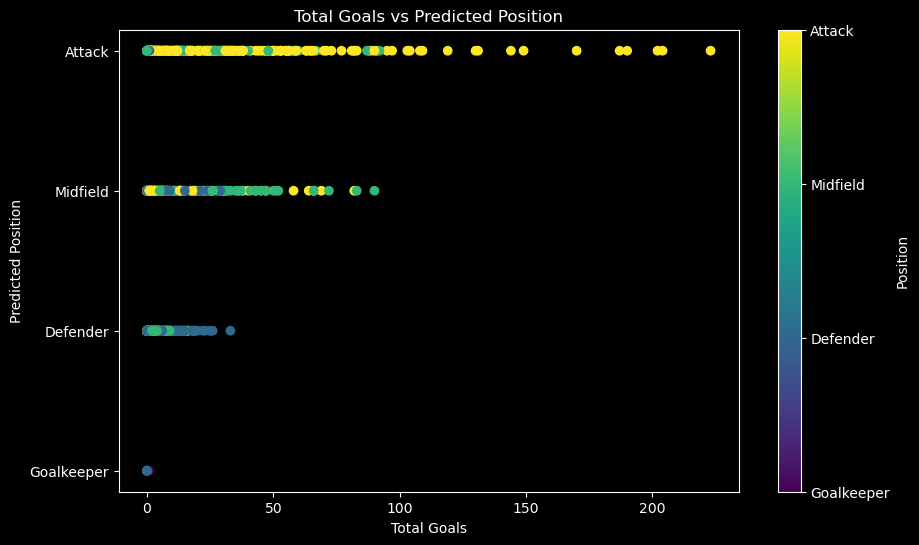

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

# Map numeric labels back to original string labels
position_labels_map = {
    0: 'Goalkeeper',
    1: 'Defender',
    2: 'Midfield',
    3: 'Attack'
}

# Scatter plot for Total Goals vs Predicted Position
plt.figure(figsize=(10, 6))
scatter = plt.scatter(test_pred_pd["TOTAL_GOALS"], test_pred_pd["PREDICTION"], c=test_pred_pd["POSITION_ENCODED"], cmap='viridis')
plt.title('Total Goals vs Predicted Position')
plt.xlabel('Total Goals')
plt.ylabel('Predicted Position')
plt.yticks(list(position_labels_map.keys()), list(position_labels_map.values()))  # Set y-axis ticks as string labels
plt.colorbar(scatter, ticks=list(position_labels_map.keys()), label='Position', format=position_labels_map.get)
plt.show()



# Model Performance Considerations

As mentioned at the beginning, accuracy was not the objective today, yet it's insightful to consider a few observations:

- The model occasionally blurred the lines between attacking and midfield positions, but overall, it didn't result in a lot of major misclassifications. 
- An example of this misclassification is observed for Jude Bellingham and Christian Eriksen in their Attacking-Midfield Role. Despite the model predicting them as attackers, their actual position and sub-position are attacking-midfielders. This slight misclassification is common across the dataset and could be maybe improved by incorporating a few additional features such as tackles, number of passes, and average kilometers run.
- Remarkable, at least, that there were few instances of goalkeepers being mistakenly placed in an attacking role and vice versa.

In [22]:
from snowflake.snowpark.functions import col, when

# Select relevant columns and add a column for Correct/Wrong prediction
result = (
    test_pred
    .select(
        "NAME",
        "CURRENT_CLUB_NAME",
        "POSITION",
        "SUB_POSITION",
        when(col("PREDICTION") == 0, "Goalkeeper")
        .when(col("PREDICTION") == 1, "Defender")
        .when(col("PREDICTION") == 2, "Midfield")
        .when(col("PREDICTION") == 3, "Attack")
        .otherwise("Unknown")
        .alias("PREDICTED_POSITION"),
        when(col("PREDICTION") == col("POSITION_ENCODED"), "Correct")
        .otherwise("Wrong")
        .alias("Prediction_Status")
    )
    .orderBy(col("LATEST_MARKET_VALUE_IN_EUR").desc())
    .limit(20)
)

# Show the results
result.show()


------------------------------------------------------------------------------------------------------------------------------
|"NAME"                 |"CURRENT_CLUB_NAME"  |"POSITION"  |"SUB_POSITION"      |"PREDICTED_POSITION"  |"PREDICTION_STATUS"  |
------------------------------------------------------------------------------------------------------------------------------
|Kylian Mbappé          |Paris Saint-Germain  |Attack      |Centre-Forward      |Attack                |Correct              |
|Pedri                  |FC Barcelona         |Midfield    |Central Midfield    |Midfield              |Correct              |
|Saúl Ñíguez            |Atlético de Madrid   |Midfield    |Central Midfield    |Midfield              |Correct              |
|Serge Gnabry           |Bayern Munich        |Attack      |Right Winger        |Attack                |Correct              |
|Rafael Leão            |AC Milan             |Attack      |Left Winger         |Attack                |Correct

# Conclusions

I'm sure that a more extensive feature engineering and additional attributes might further improve the accuracy of the model. 

HINT: A good feature to add would be the average tackle and fouls. 

Have fun! 